In [21]:
from langgraph.graph import START, END, StateGraph
from typing import TypedDict
from langgraph.types import Send, interrupt, Command
import subprocess
import textwrap
from openai import OpenAI
from dotenv import load_dotenv
from langchain.chat_models import init_chat_model
from typing_extensions import Annotated
import operator
import os
import base64
from langgraph.checkpoint.memory import InMemorySaver


load_dotenv("../../.env")


llm = init_chat_model("ollama:gpt-oss:120b", base_url=os.environ.get("OLLAMA_BASE_URL"))
memory = InMemorySaver()


class State(TypedDict):
    video_file: str
    audio_file: str
    transcription: str
    summaries: Annotated[list[str], operator.add]
    thumbnail_prompts: Annotated[list[str], operator.add]
    thumbnail_sketches: Annotated[list[str], operator.add]
    final_summary: str
    user_feedback: str
    chosen_prompt: str

In [22]:
def extract_audio(state: State):
    output_file = state["video_file"].replace("mp4", "mp3")
    command = [
        "ffmpeg",
        "-i",
        state["video_file"],
        "-filter:a",
        "atempo=2.0",
        "-y",
        output_file,
    ]
    subprocess.run(command)
    return {
        "audio_file": output_file,
    }


def transcribe_audio(state: State):
    client = OpenAI()
    with open(state["audio_file"], "rb") as audio_file:
        transcription = client.audio.transcriptions.create(
            model="whisper-1",
            response_format="text",
            file=audio_file,
            language="en",
            prompt="Netherlands, Rotterdam, Amsterdam, The Hage",
        )
        return {
            "transcription": transcription,
        }


def dispatch_summarizers(state: State):
    transcription = state["transcription"]
    chunks = []
    for i, chunk in enumerate(textwrap.wrap(transcription, 500)):
        chunks.append({"id": i + 1, "chunk": chunk})
    return [Send("summarize_chunk", chunk) for chunk in chunks]


def summarize_chunk(chunk):
    chunk_id = chunk["id"]
    chunk = chunk["chunk"]

    response = llm.invoke(
        f"""
        Please summarize the following text.

        Text: {chunk}
        """
    )
    summary = f"[Chunk {chunk_id}] {response.content}"
    return {
        "summaries": [summary],
    }


def mega_summary(state: State):
    all_summaries = "\n".join(state["summaries"])
    prompt = f"""
        You are given multiple summaries of different chunks from a video transcription.
        
        Please create a comprehensive final summary that combines all the key points.

        Individual summaries:

        {all_summaries}
    """
    response = llm.invoke(prompt)
    return {
        "final_summary": response.content,
    }


def dispatch_artists(state: State):
    return [
        Send(
            "generate_thumbnails",
            {
                "id": i,
                "summary": state["final_summary"],
            },
        )
        for i in [1, 2, 3, 4, 5]
    ]


def generate_thumbnails(args):
    thumbnail_id = args["id"]
    summary = args["summary"]
    prompt = f"""
    Based on this video summary, create a detailed visual prompt for a YouTube thumbnail.

    Create a detailed prompt for generating a thumbnail image that would attract viewers. Inlcude:
        - Main visual elements
        - Color scheme
        - Text overlay suggestions
        - Overall composition

    Summary: {summary}
    """
    response = llm.invoke(prompt)
    thumbnail_prompt = response.content

    client = OpenAI()
    result = client.images.generate(
        model="gpt-image-1-mini",
        prompt=thumbnail_prompt,
        quality="low",
        moderation="low",
        size="auto",
    )
    image_byter = base64.b64decode(result.data[0].b64_json)
    filename = f"thumbnail_{thumbnail_id}.jpg"
    with open(filename, "wb") as file:
        file.write(image_byter)

    return {
        "thumbnail_prompts": [thumbnail_prompt],
        "thumbnail_sketches": [filename],
    }


def human_feedback(state: State):
    feedback = interrupt(
        {
            "chosen_thumbnail": "Which thumbnail do you like the most?",
            "feedback": "Provide any feedback or changes you'd like for the final thumbnail.",
        }
    )
    user_feedback = feedback["user_feedback"]
    chosen_prompt = feedback["chosen_prompt"]
    return {
        "user_feedback": user_feedback,
        "chosen_prompt": state["thumbnail_prompts"][chosen_prompt - 1],
    }


def generate_hd_thumbnail(state: State):
    chosen_prompt = state["chosen_prompt"]
    user_feedback = state["user_feedback"]
    prompt = f"""
    You are a professional YouTube thumbnail designer. Take this original thumbnail prompt and create an enhanced version that incorporates the user's specific feedback.

    ORIGINAL PROMPT:
    {chosen_prompt}

    USER FEEDBACK TO INCORPORATE:
    {user_feedback}

    Create an enhanced prompt that:
        1. Maintains the core concept from the original prompt
        2. Specifically addresses and implements the user's feedback requests
        3. Adds professional YouTube thumbnail specifications:
            - High contrast and bold visual elements
            - Clear focal points that draw the eye
            - Professional lighting and composition
            - Optimal text placement and readability with generous padding from edges
            - Colors that pop and grab attention
            - Elements that work well at small thumbnail sizes
            - IMPORTANT: Always ensure adequate white space/padding between any text and the image borders
    """

    response = llm.invoke(prompt)
    final_thumbnail_prompt = response.content

    client = OpenAI()
    result = client.images.generate(
        model="gpt-image-1",
        prompt=final_thumbnail_prompt,
        quality="high",
        moderation="low",
        size="auto",
    )

    image_byter = base64.b64decode(result.data[0].b64_json)
    filename = f"thumbnail_final.jpg"

    with open(filename, "wb") as file:
        file.write(image_byter)

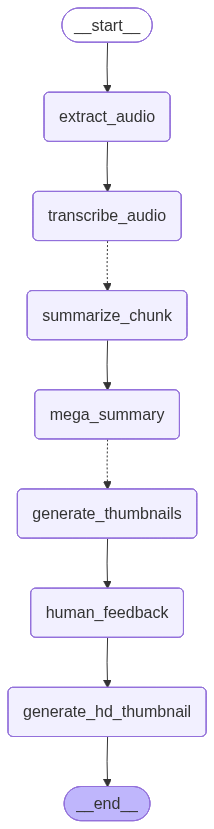

In [23]:
graph_builder = StateGraph(State)

graph_builder.add_node("extract_audio", extract_audio)
graph_builder.add_node("transcribe_audio", transcribe_audio)
graph_builder.add_node("summarize_chunk", summarize_chunk)
graph_builder.add_node("mega_summary", mega_summary)
graph_builder.add_node("generate_thumbnails", generate_thumbnails)
graph_builder.add_node("human_feedback", human_feedback)
graph_builder.add_node("generate_hd_thumbnail", generate_hd_thumbnail)

graph_builder.add_edge(START, "extract_audio")
graph_builder.add_edge("extract_audio", "transcribe_audio")
graph_builder.add_conditional_edges(
    "transcribe_audio", dispatch_summarizers, ["summarize_chunk"]
)
graph_builder.add_edge("summarize_chunk", "mega_summary")
graph_builder.add_conditional_edges(
    "mega_summary", dispatch_artists, ["generate_thumbnails"]
)
graph_builder.add_edge("generate_thumbnails", "human_feedback")
graph_builder.add_edge("human_feedback", "generate_hd_thumbnail")
graph_builder.add_edge("generate_hd_thumbnail", END)

graph = graph_builder.compile(checkpointer=memory)

config = {
    "configurable": {
        "thread_id": "1",
    }
}

graph

In [24]:
graph.invoke(
    {"video_file": "Video_Message_for_Professor_s_Retirement.mp4"},
    config=config,
)

ffmpeg version 8.0.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with Apple clang version 17.0.0 (clang-1700.4.4.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/8.0.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --

{'video_file': 'Video_Message_for_Professor_s_Retirement.mp4',
 'audio_file': 'Video_Message_for_Professor_s_Retirement.mp3',
 'transcription': 'To Professor Chung-Shan Hong, congratulations on a remarkable career. We wish you a wonderful and fulfilling retirement.\n',
 'summaries': ['[Chunk 1] Congratulations to Professor Chung‑Shan Hong on his distinguished career and best wishes for a happy, fulfilling retirement.'],
 'thumbnail_prompts': ["**YouTube Thumbnail Prompt – “A Heartfelt Tribute to Professor\u202fChung‑Shan Hong – Happy Retirement!”**  \n\n---\n\n### 1. Main Visual Elements  \n\n| Element | Description | Placement |\n|---------|-------------|-----------|\n| **Portrait of Prof.\u202fChung‑Shan Hong** | A warm, slightly‑smiling close‑up of the professor (mid‑50s‑60s, short‑gray hair, wearing a smart blazer over a collared shirt). The image should be high‑resolution, slightly desaturated to blend with the background but with eyes bright and sharp. | Center‑left, occupying ab

In [25]:
snapshot = graph.get_state(config)

snapshot.next

('human_feedback',)

In [26]:
manual_human_feedback = {
    "user_feedback": "Makesure the fella is smiling, remove any incomplete decorations or any logo, and give it a photo realistic, 3d style, with chubby circular face and white hair",
    "chosen_prompt": 1,
}

graph.invoke(
    Command(resume=manual_human_feedback),
    config=config,
)

{'video_file': 'Video_Message_for_Professor_s_Retirement.mp4',
 'audio_file': 'Video_Message_for_Professor_s_Retirement.mp3',
 'transcription': 'To Professor Chung-Shan Hong, congratulations on a remarkable career. We wish you a wonderful and fulfilling retirement.\n',
 'summaries': ['[Chunk 1] Congratulations to Professor Chung‑Shan Hong on his distinguished career and best wishes for a happy, fulfilling retirement.'],
 'thumbnail_prompts': ["**YouTube Thumbnail Prompt – “A Heartfelt Tribute to Professor\u202fChung‑Shan Hong – Happy Retirement!”**  \n\n---\n\n### 1. Main Visual Elements  \n\n| Element | Description | Placement |\n|---------|-------------|-----------|\n| **Portrait of Prof.\u202fChung‑Shan Hong** | A warm, slightly‑smiling close‑up of the professor (mid‑50s‑60s, short‑gray hair, wearing a smart blazer over a collared shirt). The image should be high‑resolution, slightly desaturated to blend with the background but with eyes bright and sharp. | Center‑left, occupying ab